Blatt 4
---

Übungstermin: 17. 05. 2017

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from numpy import sqrt, diag
from functools import partial
from helpers import load_dataset, plot, plot_df, log_plot, design_mat_polynomial, get_y, plot_weights
from numpy.linalg import inv
from numpy.random import normal
from scipy.stats import norm # pdf for normal distribution
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning) # scipy throws FutureWarning
np.random.seed(1)
# plt.style.use('dark_background')
%matplotlib inline

## Task 4.1 Cramer-Rao Schranke am Boccia-Beispiel:
<font color='#0d2b5b'>
Betrachten Sie das Boccia-Datenmodell aus dem Vorlesungsskript mit $y_i = wx^2 + \nu_i$ mit konstanter
Anfangsgeschwindigkeit $x = 0.5$ und dem Schätzer  
$$\hat\omega= \frac 1N \sum_{i=1}^N \frac{y_i}{x^2}$$
Dabei sei $\nu_i \sim \mathcal{N} (0, \sigma^2)$ normalverteiltes Rauschen mit Varianz $\sigma^2 = 0.1$.  
</font>

In [2]:
class BocciaDistribution:
    def __init__(self, sigma=0.1, x_0=0.5, w=1):
        self.sigma = sigma
        self.x_0 = x_0
        self.w = w
        self.mu = self.w * self.x_0**2

    def get_samples(self, n):
        noise = np.random.normal(0, self.sigma, n)
        ys = noise + self.mu
        return ys

In [3]:
def sample_mean(ys):
    ys = np.array(ys)
    mean = np.sum(ys, axis=0) / len(ys)
    mean = mean.reshape(ys.shape[1:])
    return mean

def sample_variance(ys):
    ys = np.array(ys)
    return np.sum((ys - sample_mean(ys))**2) / (len(ys) - 1)

def estimate_omega(x, ys):
    omega = sample_mean(ys / x**2)    
    return omega


def plot_samples(samples, distribution, label="Boccia Distribution"):
    fig, ax = plt.subplots()
    sns.distplot(samples, hist=False, rug=True, ax=ax, label=label)
    draw_arrow(distribution.mu, 0.8, "true mean", ax, color='r')
    draw_arrow(sample_mean(samples), 1.1, "sample mean", ax, color='b')

def draw_arrow(x_pos, size, label, ax, **kwargs):
    plt.arrow(x_pos, size + 0.5, 0, -size, axes=ax, width=0.005, head_length=0.3, **kwargs)
    plt.text(x_pos, size + 0.6, label, axes=ax, horizontalalignment='center', **kwargs)

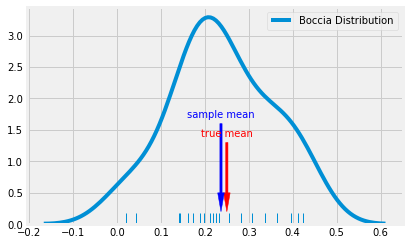

In [4]:
distribution = BocciaDistribution()
samples = distribution.get_samples(20)
plot_samples(samples, distribution)

<font color='#0d2b5b'>
Zeige experimentell über je $100$ Wiederholungen, dass für $N \in \{ 1, 2, 3, 5, 10, 100, 1000\}$
die Varianz der Schätzung, d.h. $Var(\hat\omega)$
gegen die Cramer-Rao Schranke konvergiert.
Plotte dazu $Var(\hat\omega)$ und 
$\frac{\sigma^2}{Nx^2}$
in Abhängigkeit von $N$.  
</font>

In [5]:
def calc_cramer_rao_bound(distribution, n_samples):
    return distribution.sigma**2 / (n_samples* distribution.x_0**4)

def calc_boccia_sample_variance(distribution, n_samples, n_reps=100):
    return sample_variance(
    [estimate_omega(distribution.x_0, distribution.get_samples(n_samples))
     for _ in range(n_reps)])

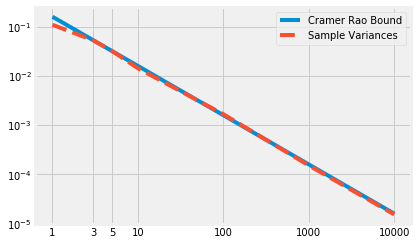

In [6]:
ns = np.array([1, 3, 5, 10, 100, 1000, 10000])
distribution = BocciaDistribution()
cramer_rao_bounds = [calc_cramer_rao_bound(distribution, n) for n in ns]
sample_variances = [calc_boccia_sample_variance(distribution, n) for n in ns]

fig, ax = plt.subplots()
ax.set_xscale('log')
ax.set_yscale('log')
ax.plot(ns, cramer_rao_bounds, label="Cramer Rao Bound")
ax.plot(ns, sample_variances, label="Sample Variances", ls='--')
plt.xticks(ns, [str(n) for n in ns], axes=ax)
ax.legend();

<font color='#1d478c'>
Wie verändern sich die Schranke und die Schätzungen bei Variation von $\sigma^2$.  
</font>

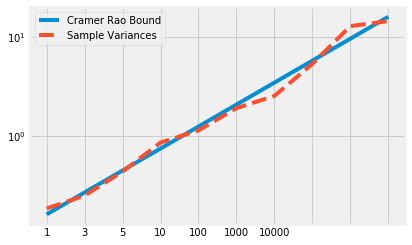

In [7]:
sigmas = np.logspace(0.001, 1, 10)
n_samples = 100
distributions = [BocciaDistribution(sigma=sigma) for sigma in sigmas]
cramer_rao_bounds = [calc_cramer_rao_bound(distribution, n_samples) for distribution in distributions]
sample_variances = [calc_boccia_sample_variance(distribution, n_samples) for distribution in distributions]

fig, ax = plt.subplots()
ax.set_xscale('log')
ax.set_yscale('log')
ax.plot(sigmas, cramer_rao_bounds, label="Cramer Rao Bound")
ax.plot(sigmas, sample_variances, label="Sample Variances", ls='--')
plt.xticks(sigmas, [str(n) for n in ns], axes=ax)
ax.legend();

## Task 4.2 Regularisierte Polynom-Regression:
<font color='#1d478c'>
Berechnen Sie die Regressionsformel für die quadratische Fehlerfunktion
$$
E = \frac12 \sum_{i=1}^N \left( y(x_i) - \hat y(x_i)\right)^2
+\lambda \frac12 \sum_{m=0}^M \hat\omega_m^2 \left(e^m-1\right)
$$
mit speziellem Regularisierungsterm gewichtet mit Parameter $\lambda$ für einen Polynomapproximator
$$
\hat y(x) = \sum_{m_0}^M \hat\omega_m^m x_m
$$
.  
</font>

Zunächst bringe ich die Fehlerfunktion in eine Matrixform.
Wie in Übung 2 ist der Fehlervector  
$\mathbf{e} = \mathbf{\hat y} - \mathbf{y}=  \mathbf{\hat\omega}^T \mathbf{x} - \mathbf{y}$  
Zudem definiere ich die Regularisierungsmatrix  

$$
\mathbf R =
\begin{pmatrix}
e^0+1 &&\Large 0\\
&\ddots &\\
\Large0&& e^n+1\\
\end{pmatrix}
$$

Damit erhalte ich

\begin{align}
E( \mathbf{\hat\omega}) &= \mathbf{e}^T \mathbf{e} + \lambda \mathbf{\hat\omega}^T \mathbf{D} \mathbf{\hat\omega} \\
&=  \mathbf{y}^T \mathbf{y} - 2\left( \mathbf{y}^T \mathbf{x \hat\omega} \right)
+ \mathbf{\hat\omega}^T \mathbf{x}^T \mathbf{x\hat\omega}
+ \lambda \mathbf{\hat\omega}^T \mathbf{D} \mathbf{\hat\omega}\\
\end{align}

Durch Nullsetzen des Gradienten der Fehlerfunktion ergibt sich:

\begin{align}
\nabla_\mathbf{\hat\omega} E(\mathbf{\hat\omega}) &= 0 \\
\rightarrow 0 &= 
-2 \mathbf{y}^T \mathbf{x}
+ 2 \mathbf{\hat\omega}^T \mathbf{x}^T \mathbf{x}
+ 2 \mathbf{\hat\omega}^T \lambda \mathbf{D}\\
\rightarrow \mathbf{y}^T \mathbf{x} &= 
\mathbf{\hat\omega}^T \mathbf{x}^T \mathbf{x}
+ \mathbf{\hat\omega}^T \lambda \mathbf{D}\\
&= \mathbf{\hat\omega}^T 
\left( \mathbf{x}^T \mathbf{x} + \lambda \mathbf{D}\right)
\\
\rightarrow \mathbf{\hat\omega}^T &= 
\mathbf{y}^T \mathbf{x} 
\left( \mathbf{x}^T \mathbf{x} + \lambda \mathbf{D}\right)^{-1}\\
\rightarrow \mathbf{\hat\omega} &= 
\left(\left(
\mathbf{x}^T \mathbf{x} + \lambda \mathbf{D}
\right)^{-1}\right)^T
\mathbf{x}^T \mathbf{y}
\end{align}

Da sowohl
$\mathbf{x}^T \mathbf{x}$ als auch $\lambda \mathbf{D}$
symmetrisch sind, gilt:
$$
\mathbf{\hat\omega} = 
\left(
\mathbf{x}^T \mathbf{x} + \lambda \mathbf{D}
\right)^{-1}
\mathbf{x}^T \mathbf{y}
$$

<font color='#1d478c'>
Welche Idee steckt hinter diesem speziellem Regularisierungsansatz und wie wirkt sich die Regularisierung
auf die Lösungen der Regression aus?
</font>

Gewichte der höheren Polynomgerade sind 'teurer', sodass im Zweifel für ein Fit geringerer Ordnung entschieden wird.

## Task 4.3 Bias-Varianz Dilemma am Beispiel der Polynom-Regression:
<font color='#1d478c'>
Untersuchen Sie den Einfluss der oben eingeführten Regularisierung auf die Schätzgenauigkeit.  
Als Datenmodell sei das Polynom $y(x, w) + \nu$ gegeben mit wahren Parametern  
$w_0 = 0.8$, $w_1 = 2.4$, $w_2 = −1.55$, $w_3 = −0.15$, $w_4 = 0.1$ und $\nu \sim\mathcal{n} (0, \sigma^2 )$
mit $\sigma^2 = 2$.  
</font>

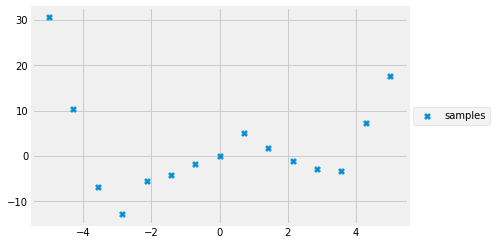

In [8]:
true_omega = [0.8, 2.4, -1.55, -0.15, 0.1]
def get_samples(sigma = 2):    
    xs = np.linspace(-5, 5, 15)
    ys = get_y(true_omega, xs) + normal(0, sigma, len(xs))
    return xs, ys
xs, ys = get_samples()
plot(xs, ys)

In [9]:
def p_inv_reg(A, weight, d_mat):
    return inv(A.T @ A + weight * d_mat) @ A.T
 
def polyfit_reg(x, y, weight, d_mat_diagonal):
    order = len(d_mat_diagonal) - 1
    x, y = [np.array(a).reshape(-1, 1) for a in [x, y]]
    design_mat = design_mat_polynomial(x, order)
    params = p_inv_reg(design_mat, weight, diag(d_mat_diagonal)) @ y
    return params.reshape(-1, 1)

<font color='#1d478c'>
Schätzen Sie wiederholt Modellparameter $\hat\omega$ für Polynome 8-ten Grades mittels der regularisierten
Regression aus Aufgabe 3.2. Erstellen Sie dazu $100$ Datensätze bestehend aus je $20$ Datenpunkten
$(x_i , y(x_i ) + \nu_i)$ mit uniform verteilten $x_i \in [−5, 5]$ und wiederholen Sie die Schätzung der Parameter
für jeden Datensatz und Regularisierungen $\lambda \in {0, 10^{−5} , 10{−4} , . . . , 10^5}$.  
</font>

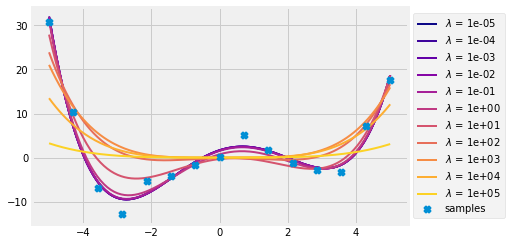

In [10]:
order = 4
lambdas = 10**np.linspace(-5, 5, 11)
d_mat_diagonal = [np.exp(m) + 1 for m in range(order + 1)]
coeff_dict = {"$\lambda$ = {:.0e}".format(weight) : polyfit_reg(xs, ys, weight, d_mat_diagonal) for weight in lambdas}
plot(xs, ys, coeff_dict, lw=2)

<font color='#1d478c'>
Welchen Einfluss hat $\lambda$ auf die Aufteilung des Schätzfehlers
$\left< ||w − \hat\omega||^2\right>$
in Bias- und Varianz-Anteile?
Plotten Sie dazu den Bias des Schätzers, d.h.
$||\left<\hat\omega\right> − w||^2$,
sowie dessen Varianz
$\left< ||\hat\omega − \left< \hat\omega \right>||^2 \right>$
in Abhängigkeit von $\lambda$.  
</font>

In [11]:
n_estimations = 100
@np.vectorize
def calc_bias(weight):
    estimated_omegas = np.array([
        polyfit_reg(*get_samples(), weight, d_mat_diagonal)
                        for _ in range(n_estimations)]).reshape(n_estimations, -1)  
    mean_omega = sample_mean(estimated_omegas)
    deviation = np.array(mean_omega - true_omega)
    return deviation.T @ deviation

@np.vectorize
def calc_variance(weight):
    estimated_omegas = np.array([
        polyfit_reg(*get_samples(), weight, d_mat_diagonal)
                        for _ in range(n_estimations)]).reshape(n_estimations, -1)  
    mean_omega = sample_mean(estimated_omegas)
    deviations = np.array([
        ((omega - mean_omega)**2).sum()
        for omega in estimated_omegas])
    return sample_mean(deviations)

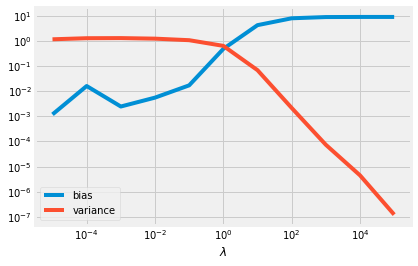

In [12]:
biases = calc_bias(lambdas)
variances = calc_variance(lambdas)

fig, ax = plt.subplots()
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('$\lambda$')
ax.plot(lambdas, biases, label="bias")
ax.plot(lambdas, variances, label="variance")
ax.legend();